In [381]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

from sklearn.feature_selection import SelectPercentile, RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate, cross_val_score, RepeatedStratifiedKFold,\
StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay, precision_recall_curve, confusion_matrix, recall_score, precision_score
from sklearn.exceptions import ConvergenceWarning
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

import optuna

from scipy import stats
from scipy.stats import chi2_contingency
from datetime import datetime, date

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [382]:
sba=pd.read_csv("SBAnational.csv")
sba.head()

C:\Users\susana\AppData\Local\Temp\ipykernel_27104\4236285489.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  sba=pd.read_csv("SBAnational.csv")


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [383]:
sba.shape

(899164, 27)

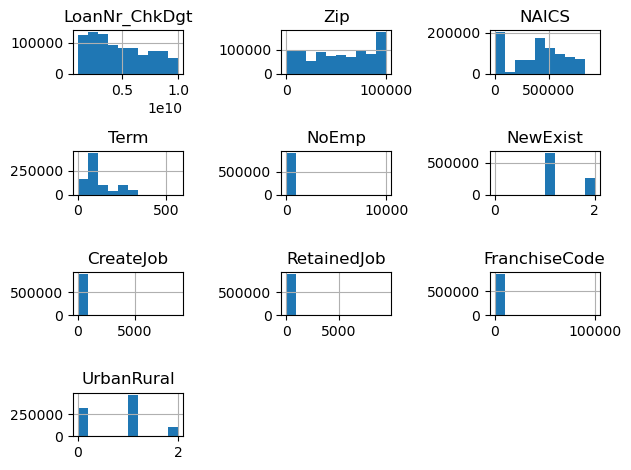

In [384]:
sba.hist()
plt.tight_layout()
plt.show()

In [385]:
print(f'Object columns: {len(sba.select_dtypes(include="object").columns)}')
print(f'Object columns: {len(sba.select_dtypes(include="number").columns)}')

Object columns: 17
Object columns: 10


In [386]:
sba.isnull().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

In [387]:
sba.duplicated().sum()

0

In [388]:
sba.drop('ChgOffDate', axis=1, inplace=True)

In [389]:
sba['MIS_Status'].value_counts()

P I F     739609
CHGOFF    157558
Name: MIS_Status, dtype: int64

In [390]:
top_5_state = sba['State'].value_counts(normalize=True).sort_values(ascending=False).head().index

In [391]:
top_5_state

Index(['CA', 'TX', 'NY', 'FL', 'PA'], dtype='object')

In [392]:
sba5 = sba[sba['State']=='CA'].copy()
sba5.drop('State', axis=1, inplace=True)

In [393]:
sba5.dropna(subset='MIS_Status', inplace=True)

In [394]:
sba5['MIS_Status'] = np.where(sba5['MIS_Status']=='P I F', 0, 1)

In [395]:
sba5['ApprovalDate']

28         7-Feb-06
48        25-Mar-97
55        26-Mar-97
62         7-Feb-06
63        28-Feb-97
            ...    
899106    27-Feb-97
899140    27-Feb-97
899146    27-Feb-97
899157    27-Feb-97
899161    27-Feb-97
Name: ApprovalDate, Length: 130488, dtype: object

In [396]:
#Nos quedamos con el mes y año de aprobación 

In [397]:
sba5['ApprovalMonth'] = sba5['ApprovalDate'].str.split('-').str[1]
sba5['ApprovalYear'] = sba5['ApprovalDate'].str.split('-').str[2]
sba5['ApprovalYear']=sba5['ApprovalYear'].apply(pd.to_numeric)
sba5.drop('ApprovalDate', axis=1, inplace=True)

In [398]:
sba5['NAICS'].value_counts()

0         28680
722110     3802
621210     2706
722211     2387
811111     2336
          ...  
926120        1
333313        1
111130        1
331512        1
334517        1
Name: NAICS, Length: 1195, dtype: int64

In [399]:
sba5['NAICS'] = sba5['NAICS'].astype('string')

naics_to_sector = {
    '11': 'Agriculture, Forestry, Fishing and Hunting',
    '21': 'Mining, Quarrying, and Oil and Gas Extraction',
    '22': 'Utilities',
    '23': 'Construction',
    '31-33': 'Manufacturing',
    '42': 'Wholesale Trade',
    '44-45': 'Retail Trade',
    '48-49': 'Transportation and Warehousing',
    '51': 'Information',
    '52': 'Finance and Insurance',
    '53': 'Real Estate and Rental and Leasing',
    '54': 'Professional, Scientific, and Technical Services',
    '55': 'Management of Companies and Enterprises',
    '56': 'Administrative and Support and Waste Management and Remediation Services',
    '61': 'Educational Services',
    '62': 'Health Care and Social Assistance',
    '71': 'Arts, Entertainment, and Recreation',
    '72': 'Accommodation and Food Services',
    '81': 'Other Services (except Public Administration)',
    '92': 'Public Administration'
}

In [400]:
def get_sector(naics_code):
    first_two = naics_code[:2]
    if first_two in ['31', '44', '48']:
        if first_two == '31':
            return naics_to_sector['31-33']
        elif first_two == '44':
            return naics_to_sector['44-45']
        else:
            return naics_to_sector['48-49']
    else:
        return naics_to_sector.get(first_two, 'Unknown Sector')
    
sba5['Sector'] = sba5['NAICS'].apply(get_sector)
sba5.drop('NAICS', axis=1, inplace=True)

In [401]:
sba5['Sector'].value_counts()

Unknown Sector                                                              42725
Retail Trade                                                                13349
Wholesale Trade                                                             10912
Professional, Scientific, and Technical Services                            10867
Other Services (except Public Administration)                               10028
Accommodation and Food Services                                              8969
Construction                                                                 8334
Health Care and Social Assistance                                            7705
Administrative and Support and Waste Management and Remediation Services     3954
Manufacturing                                                                2398
Transportation and Warehousing                                               2176
Real Estate and Rental and Leasing                                           2141
Information     

In [402]:
sba5['Term'].isnull().sum()

0

In [403]:
sba5['TermGroup'] = np.where(sba5['Term']<=90,'Below 3 months',
                            np.where((sba5['Term']>90) & (sba5['Term']<=180), '3-6 months',
                            np.where((sba5['Term']>180) & (sba5['Term']<=365), '6-12 months', 'More Than a Year')))
display(sba5[['Term', 'TermGroup']].sample(10))
sba5.drop('Term', axis=1, inplace=True)

,Term,TermGroup
430430,84,Below 3 months
43433,300,6-12 months
37873,25,Below 3 months
173850,120,3-6 months
684959,95,3-6 months
45176,84,Below 3 months
861014,120,3-6 months
3141,84,Below 3 months
79976,84,Below 3 months
295219,28,Below 3 months


In [404]:
sba5['NewExist'].value_counts(dropna=False)

1.0    108836
2.0     21529
0.0       112
NaN        11
Name: NewExist, dtype: int64

In [405]:
sba5 = sba5[sba5['NewExist']!=0]
sba5 = sba5.dropna(subset='NewExist')

In [406]:
sba5['BalanceGross'].value_counts()

$0.00     130365
Name: BalanceGross, dtype: int64

In [407]:
sba5.drop('BalanceGross', axis=1, inplace=True)

In [408]:
sba5['ChgOffPrinGr'].value_counts()

$0.00           105563
$50,000.00         462
$35,000.00         316
$10,000.00         306
$100,000.00        208
                 ...  
$661,243.00          1
$23,788.00           1
$144,699.00          1
$39,941.00           1
$183,031.00          1
Name: ChgOffPrinGr, Length: 19026, dtype: int64

In [409]:
sba5.drop('ChgOffPrinGr', axis=1, inplace=True)

In [410]:
sba5.drop(['SBA_Appv','DisbursementGross','ApprovalFY'], axis=1, inplace=True)

In [411]:
sba5.head()

,LoanNr_ChkDgt,Name,City,Zip,Bank,BankState,NoEmp,NewExist,CreateJob,RetainedJob,...,UrbanRural,RevLineCr,LowDoc,DisbursementDate,MIS_Status,GrAppv,ApprovalMonth,ApprovalYear,Sector,TermGroup
28,1000506000,WEYLAND CORPORATION,CAMARILLO,93010,WELLS FARGO BANK NATL ASSOC,SD,18,2.0,5,23,...,1,Y,N,28-Feb-06,0,"$100,000.00",Feb,6,Educational Services,Below 3 months
48,1000685001,ANYWHERE SPORTS PRODUCTIONS,Marina del Ray,90292,WELLS FARGO BANK NATL ASSOC,SD,6,1.0,0,0,...,0,Y,N,31-Oct-97,0,"$25,000.00",Mar,97,Unknown Sector,Below 3 months
55,1000715008,John Dailey,Castro Valley,94546,WELLS FARGO BANK NATL ASSOC,SD,2,1.0,0,0,...,0,0,N,31-May-99,0,"$15,000.00",Mar,97,Unknown Sector,Below 3 months
62,1000746002,ANGEL,LOS ANGELES,60014,BBCN BANK,CA,20,2.0,20,20,...,1,0,N,28-Feb-06,0,"$35,000.00",Feb,6,Manufacturing,Below 3 months
63,1000754002,"MCCRANEY, INC.",SANTA ANA,92703,BANK OF THE WEST,CA,50,1.0,0,0,...,0,0,N,31-Mar-97,0,"$745,000.00",Feb,97,Unknown Sector,6-12 months


In [412]:
sba5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130365 entries, 28 to 899161
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LoanNr_ChkDgt     130365 non-null  int64  
 1   Name              130365 non-null  object 
 2   City              130359 non-null  object 
 3   Zip               130365 non-null  int64  
 4   Bank              130233 non-null  object 
 5   BankState         130232 non-null  object 
 6   NoEmp             130365 non-null  int64  
 7   NewExist          130365 non-null  float64
 8   CreateJob         130365 non-null  int64  
 9   RetainedJob       130365 non-null  int64  
 10  FranchiseCode     130365 non-null  int64  
 11  UrbanRural        130365 non-null  int64  
 12  RevLineCr         129861 non-null  object 
 13  LowDoc            130194 non-null  object 
 14  DisbursementDate  130097 non-null  object 
 15  MIS_Status        130365 non-null  int32  
 16  GrAppv            1

In [413]:
sba5['RevLineCr'].value_counts()

N    52140
0    45653
Y    29697
T     2359
1        7
`        4
4        1
Name: RevLineCr, dtype: int64

In [414]:
sba5 = sba5[sba5['RevLineCr'].isin(['N','Y'])]

In [415]:
sba5['LowDoc'].value_counts()

N    78034
Y     3178
0      376
S       45
C       27
A        5
R        2
Name: LowDoc, dtype: int64

In [416]:
sba5 = sba5[sba5['LowDoc'].isin(['N','Y'])]

In [417]:
sba5.dropna(subset=['Bank', 'BankState', 'City', 'LowDoc'], inplace=True)

In [418]:
sba5_copy = sba5.copy()

In [419]:
count_bankst = sba5['BankState'].value_counts().to_frame().reset_index().rename(columns={'count':'BankstCount'})

In [420]:
# We convert BankState that appeared under 15 times into 'OTHER'
count_bankst['BankState'] = count_bankst['BankState'].astype(str)
sba5 = sba5.merge(count_bankst, on='BankState', how='left')

In [142]:
bankstate_counts = sba5['BankState'].value_counts()
sba5['NewBankState'] = np.where(bankstate_counts[sba5['BankState']].values > 15, sba5['BankState'], 'OTHER')
sba5.drop(['BankState'], axis=1, inplace=True)

In [143]:
sba5.drop(['Name', 'LoanNr_ChkDgt', 'Zip'], axis=1, inplace=True)

In [144]:
sba5['FranchiseCode'].value_counts()

1        55978
0        22947
78760      118
5725        47
50564       46
         ...  
52956        1
42599        1
51570        1
23350        1
84475        1
Name: FranchiseCode, Length: 521, dtype: int64

In [145]:
sba5['IsFranchise'] = np.where(((sba5['FranchiseCode']==1) | (sba5['FranchiseCode']==0)), 'Y', 'N')
sba5.drop('FranchiseCode', axis=1, inplace=True)

In [148]:
sba5.columns

Index(['City', 'Bank', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementDate', 'MIS_Status',
       'GrAppv', 'ApprovalMonth', 'ApprovalYear', 'Sector', 'TermGroup',
       'index_x', 'index_y', 'NewBankState', 'IsFranchise'],
      dtype='object')

In [149]:
sba5.drop(columns=['DisbursementDate','index_x','index_y'],inplace=True)

In [150]:
sba5['City'] = sba5['City'].str.upper()

In [170]:
count_city = sba5['City'].value_counts().to_frame().reset_index().rename(columns={'index':'City','City': 'City_Count'})

In [172]:
count_city[(count_city['City_Count']>25)&(count_city['City_Count']<=50)]

,City,City_Count
308,ORANGEVALE,50
309,NORTH HIGHLANDS,50
310,SAUSALITO,50
311,SAN ANSELMO,49
312,IRWINDALE,49
...,...,...
418,TEMPLE CITY (RUDELL),27
419,DESERT HOT SPRINGS,26
420,MONTROSE,26
421,NORTHRIDGE (NORTH LOS ANGELES),26


In [173]:
sba5 = sba5.merge(count_city, on='City')

In [174]:
sba5['NewCity'] = np.where(sba5['City_Count']>100, sba5['City'], 'OTHER')

In [175]:
sba5.drop(['City', 'City_Count'],axis=1,inplace=True)

In [176]:
sba5.columns

Index(['Bank', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'UrbanRural',
       'RevLineCr', 'LowDoc', 'MIS_Status', 'GrAppv', 'ApprovalMonth',
       'ApprovalYear', 'Sector', 'TermGroup', 'NewBankState', 'IsFranchise',
       'NewCity'],
      dtype='object')

In [177]:
sba5['Bank'] = sba5['Bank'].str.upper()

In [181]:
count_bank = sba5['Bank'].value_counts().to_frame().reset_index().rename(columns={'index':'Bank','Bank': 'Bank_Count'})

In [182]:
count_bank[(count_bank['Bank_Count']>1)&(count_bank['Bank_Count']<=29)]

,Bank,Bank_Count
141,EXCHANGE BANK,29
142,PREMIER VALLEY BANK,29
143,FIRST REPUBLIC BANK,29
144,FDIC/MECHANICS BANK,28
145,GROW AMERICA FUND INC,28
...,...,...
352,CHETCO FCU,2
353,NEW VENTURES CAP. DEVEL CO,2
354,FIRST FINANCIAL BANK,2
355,"BANK OF NEVADA, A DIVISION OF",2


In [183]:
sba5 = sba5.merge(count_bank, on='Bank')

In [184]:
sba5['NewBank'] = np.where(sba5['Bank_Count']>100, sba5['Bank'], 'OTHER')

In [185]:
sba5.drop(['Bank', 'Bank_Count'], axis=1, inplace=True)

In [186]:
sba5['UrbanRural'] = np.where(sba5['UrbanRural']==1, 'Urban',
                             np.where(sba5['UrbanRural']==2, 'Rural', 'Undefined'))

In [187]:
sba5.drop('GrAppv', axis=1, inplace=True)

In [188]:
sba5.rename(columns={'MIS_Status':'ChargeOff'}, inplace=True)
sba5['ChargeOff'] = sba5['ChargeOff'].astype('category')

In [197]:
sba_cat = sba5.select_dtypes(include='object')
sba_num = sba5.select_dtypes(exclude='object')

In [198]:
for col in sba_cat.columns:
    sba_cat[col] = sba_cat[col].astype('category')

In [199]:
sba_cat.columns

Index(['UrbanRural', 'RevLineCr', 'LowDoc', 'ApprovalMonth', 'Sector',
       'TermGroup', 'NewBankState', 'IsFranchise', 'NewCity', 'NewBank'],
      dtype='object')

In [200]:
sba_cat.head()

,UrbanRural,RevLineCr,LowDoc,ApprovalMonth,Sector,TermGroup,NewBankState,IsFranchise,NewCity,NewBank
0,Urban,Y,N,Feb,Educational Services,Below 3 months,SD,Y,CAMARILLO,WELLS FARGO BANK NATL ASSOC
1,Urban,Y,N,Aug,Retail Trade,Below 3 months,CA,Y,CAMARILLO,WELLS FARGO BANK NATL ASSOC
2,Undefined,N,N,Nov,Unknown Sector,6-12 months,SD,Y,CAMARILLO,WELLS FARGO BANK NATL ASSOC
3,Undefined,N,N,Nov,Unknown Sector,3-6 months,CA,Y,CAMARILLO,WELLS FARGO BANK NATL ASSOC
4,Urban,Y,N,Jun,Health Care and Social Assistance,Below 3 months,SD,Y,CAMARILLO,WELLS FARGO BANK NATL ASSOC


In [212]:
sba5.dtypes

NoEmp               int64
NewExist          float64
CreateJob           int64
RetainedJob         int64
UrbanRural         object
RevLineCr          object
LowDoc             object
ChargeOff        category
ApprovalMonth      object
ApprovalYear        int64
Sector             object
TermGroup          object
NewBankState       object
IsFranchise        object
NewCity            object
NewBank            object
dtype: object

In [238]:
chgoff_=sba5.groupby("UrbanRural")['ChargeOff'].value_counts(normalize=True).to_frame()
chgoff_

ChargeOff
UrbanRural             
Rural      0   0.670098
           1   0.329902
Undefined  0   0.953677
           1   0.046323
Urban      0   0.670827
           1   0.329173

In [239]:
chgoff_.columns = ['Proportion']
chgoff_

Proportion
UrbanRural              
Rural      0    0.670098
           1    0.329902
Undefined  0    0.953677
           1    0.046323
Urban      0    0.670827
           1    0.329173

In [244]:
chgoff_ = chgoff_.reset_index().rename(columns={'level_1': 'ChargeOff'}).pivot(columns='ChargeOff', index="UrbanRural", values='Proportion')
chgoff_

ChargeOff,0,1
UrbanRural,,
Rural,0.670098,0.329902
Undefined,0.953677,0.046323
Urban,0.670827,0.329173


<Axes: xlabel='UrbanRural'>

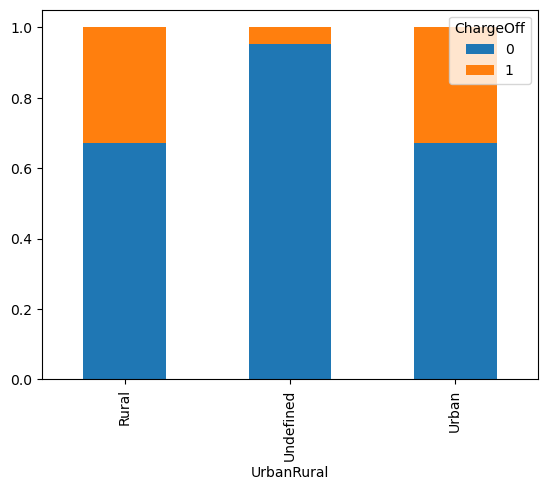

In [246]:
chgoff_.plot(kind='bar', stacked=True)

In [250]:
def compare_column_ChargeOff(column):
    contingency = sba5.groupby([column, 'ChargeOff']).agg({'ChargeOff':'count'}).rename(columns={'ChargeOff':'Count'})\
                .reset_index().pivot(index=column, columns='ChargeOff', values='Count')

    
    
    stat, p, dof, expected = chi2_contingency(contingency)
    if(p<0.05):
        print(f'Column {column} has strong relationship with ChargeOff.')
    else:
        print(f'Column {column} has weak relationship with ChargeOff.')

    chgoff_=sba5.groupby(column)['ChargeOff'].value_counts(normalize=True).to_frame()
    chgoff_.columns = ['Proportion']
    chgoff_ = chgoff_.reset_index().rename(columns={'level_1': 'ChargeOff'}).pivot(columns='ChargeOff', index=column, values='Proportion')

    chgoff_.plot(kind='bar', stacked=True, figsize=(16,10))
    
    plt.tight_layout()
    plt.show()

Column UrbanRural has strong relationship with ChargeOff.


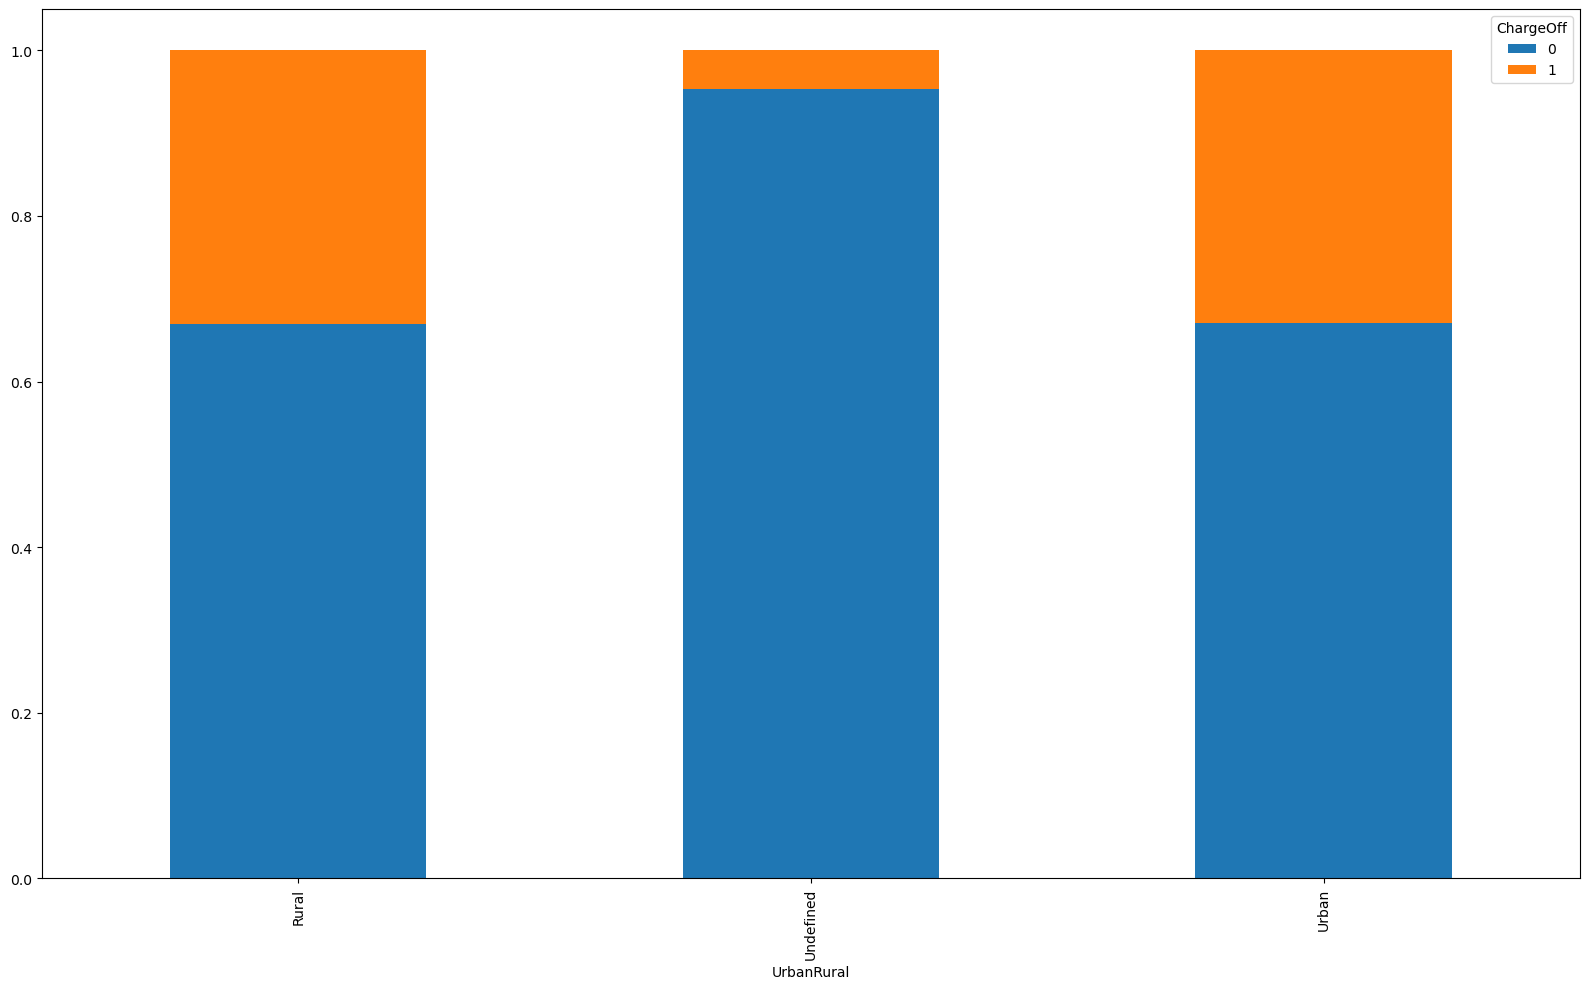

Column RevLineCr has strong relationship with ChargeOff.


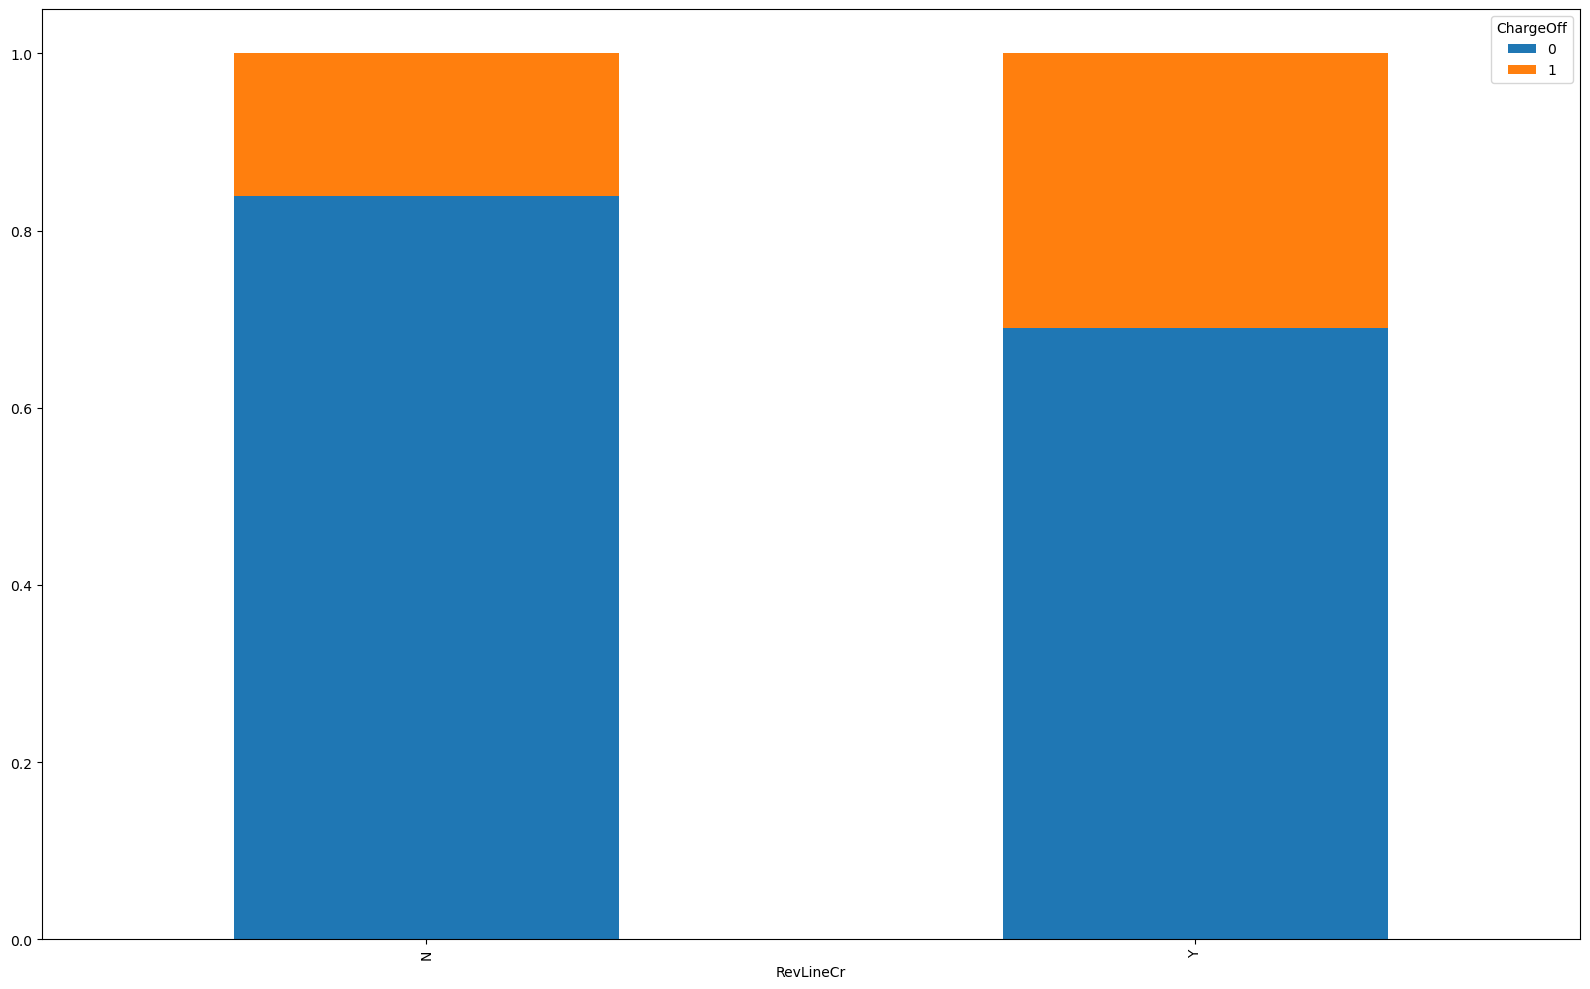

Column LowDoc has strong relationship with ChargeOff.


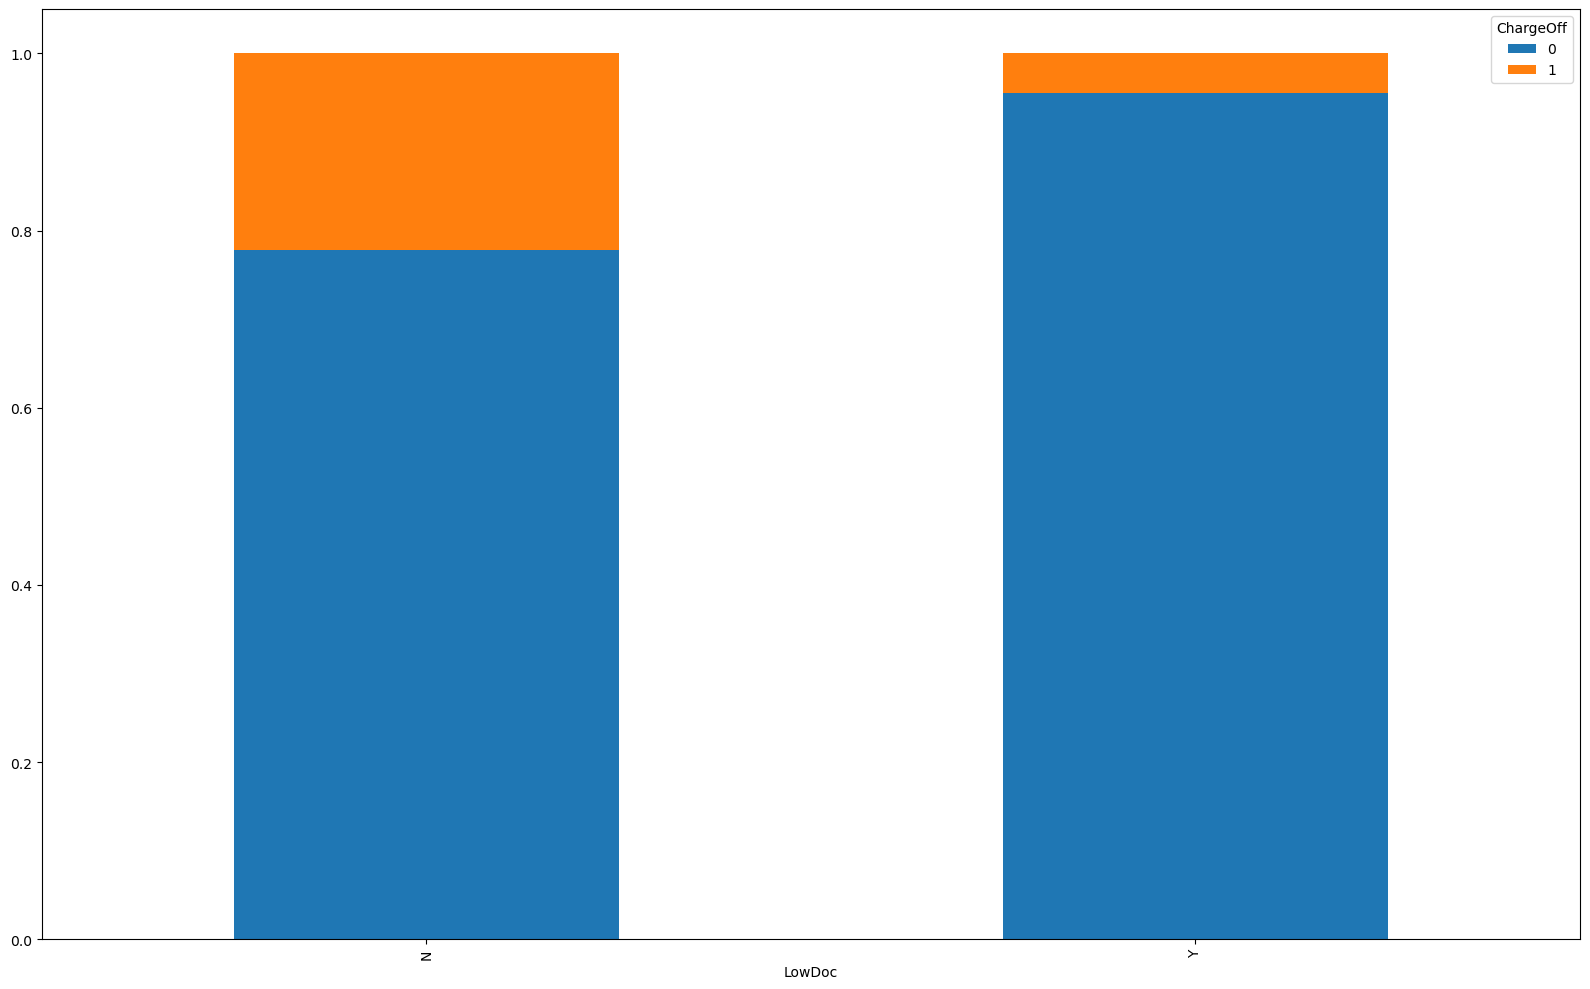

Column ApprovalMonth has strong relationship with ChargeOff.


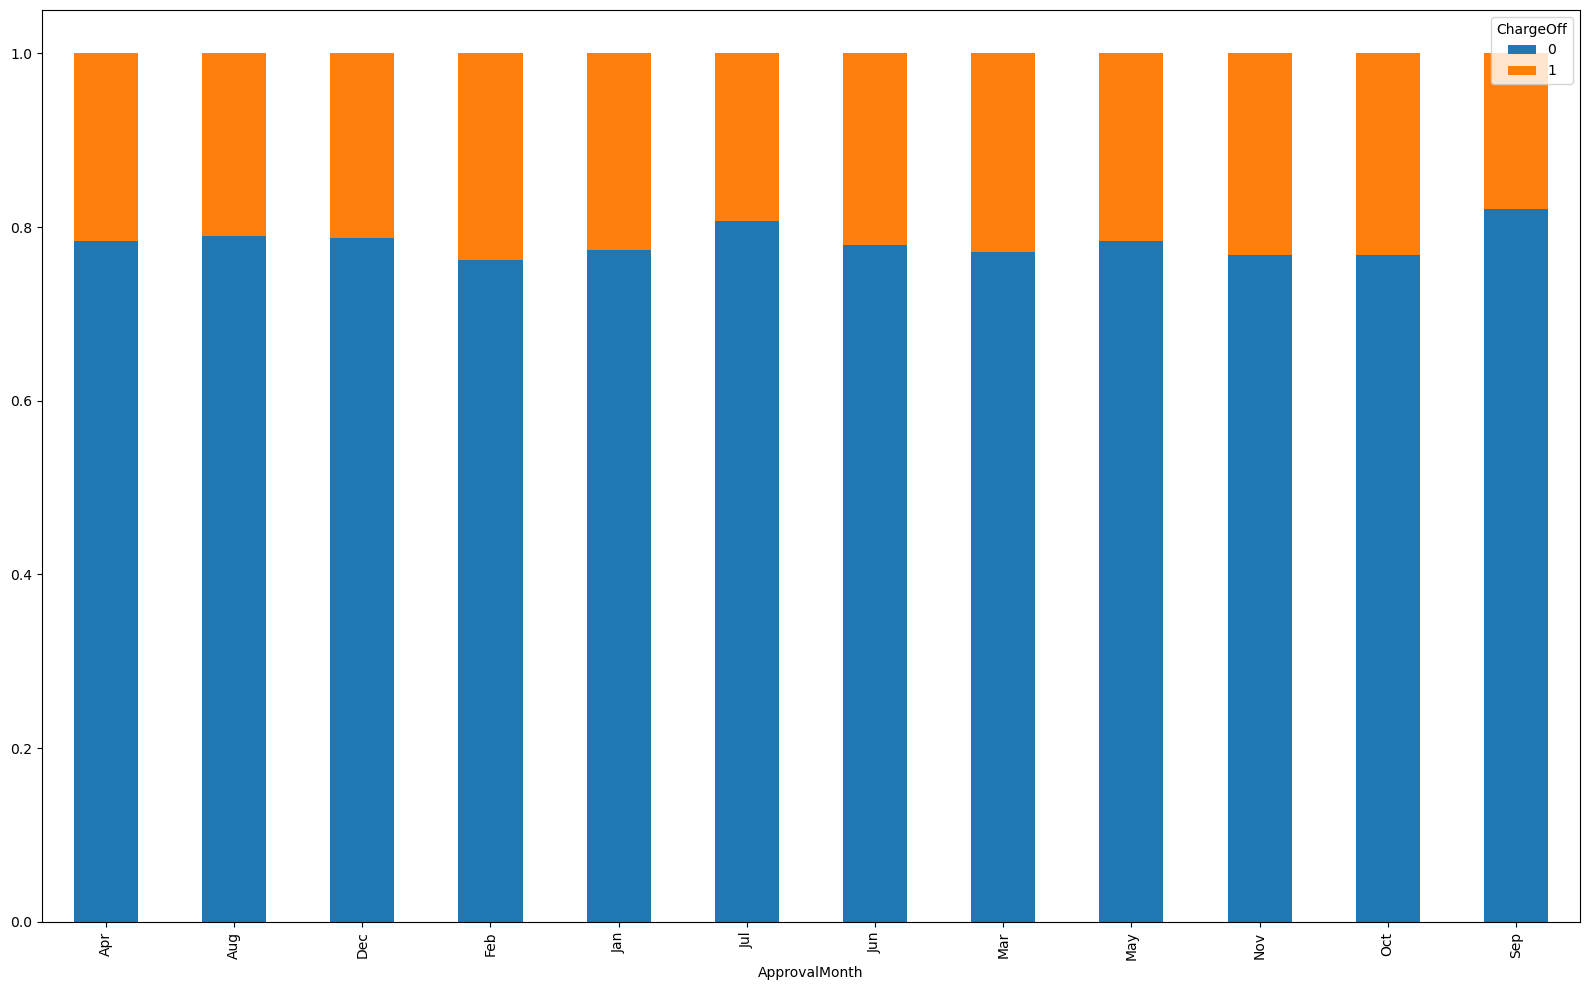

Column Sector has strong relationship with ChargeOff.


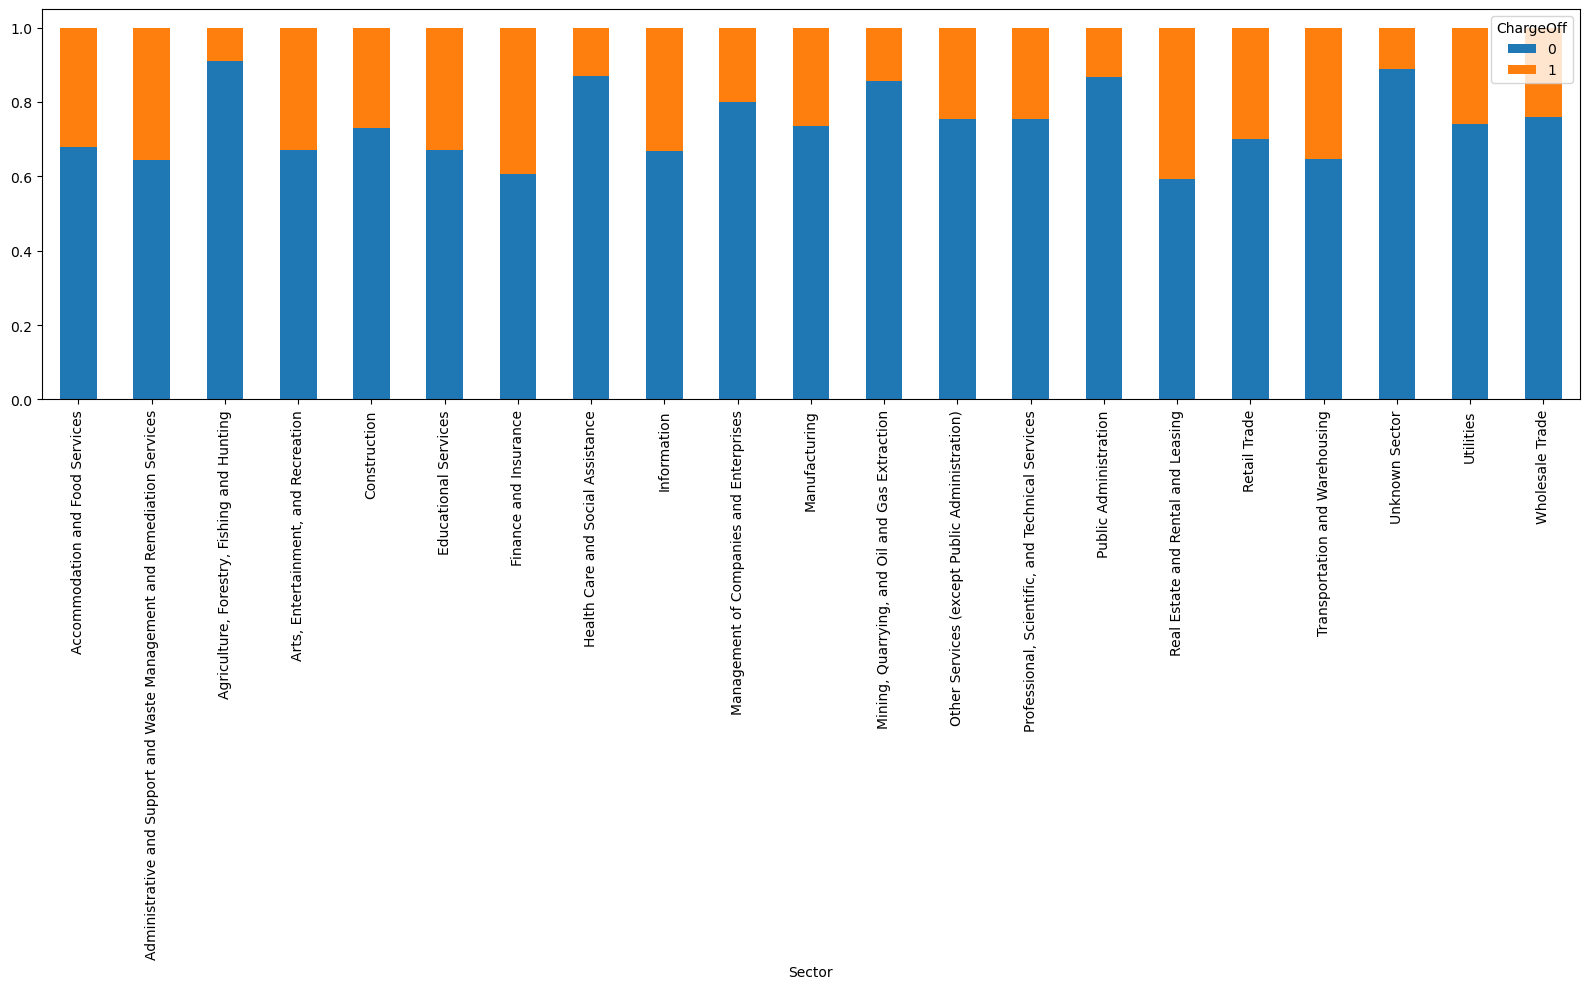

Column TermGroup has strong relationship with ChargeOff.


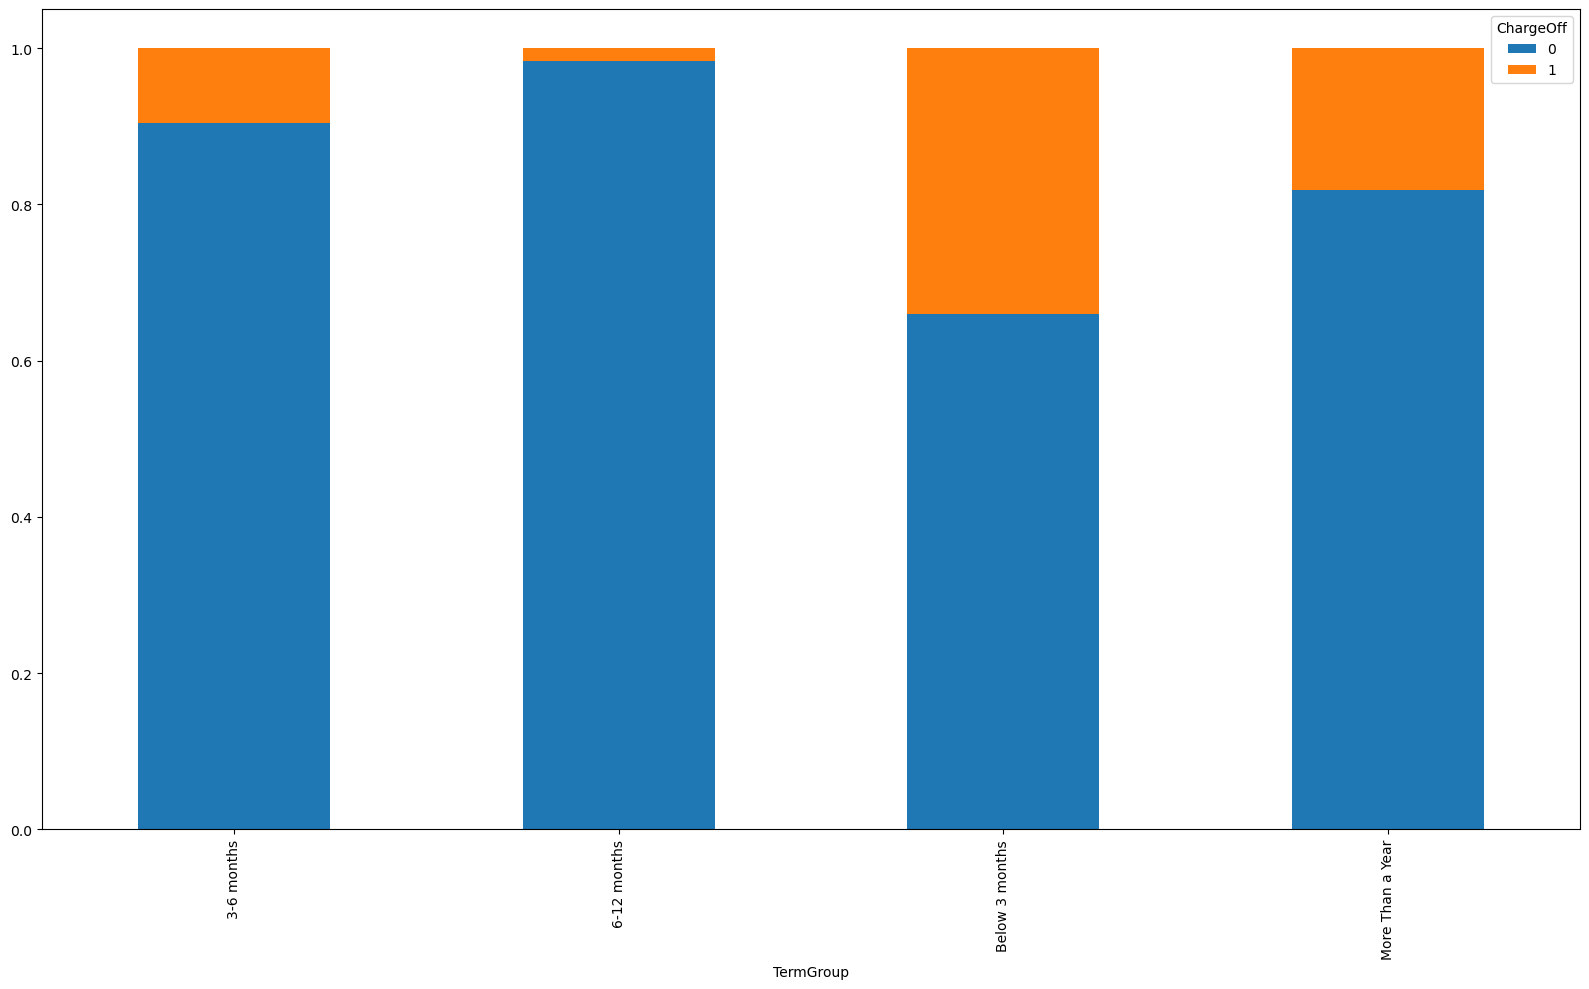

Column NewBankState has strong relationship with ChargeOff.


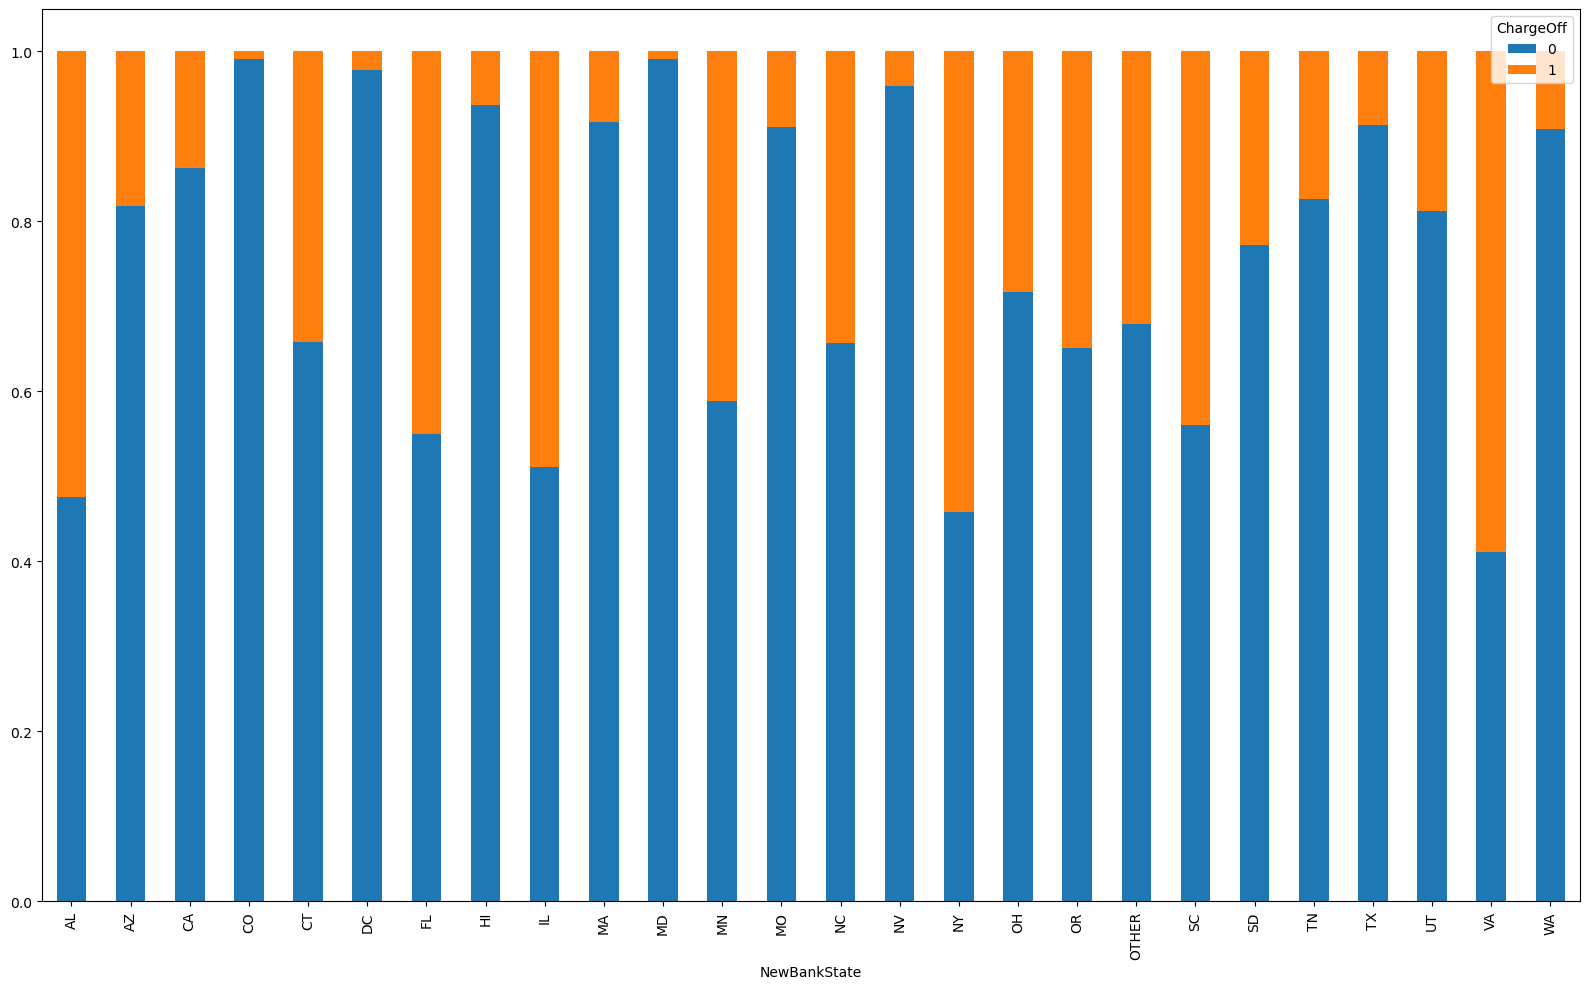

Column IsFranchise has strong relationship with ChargeOff.


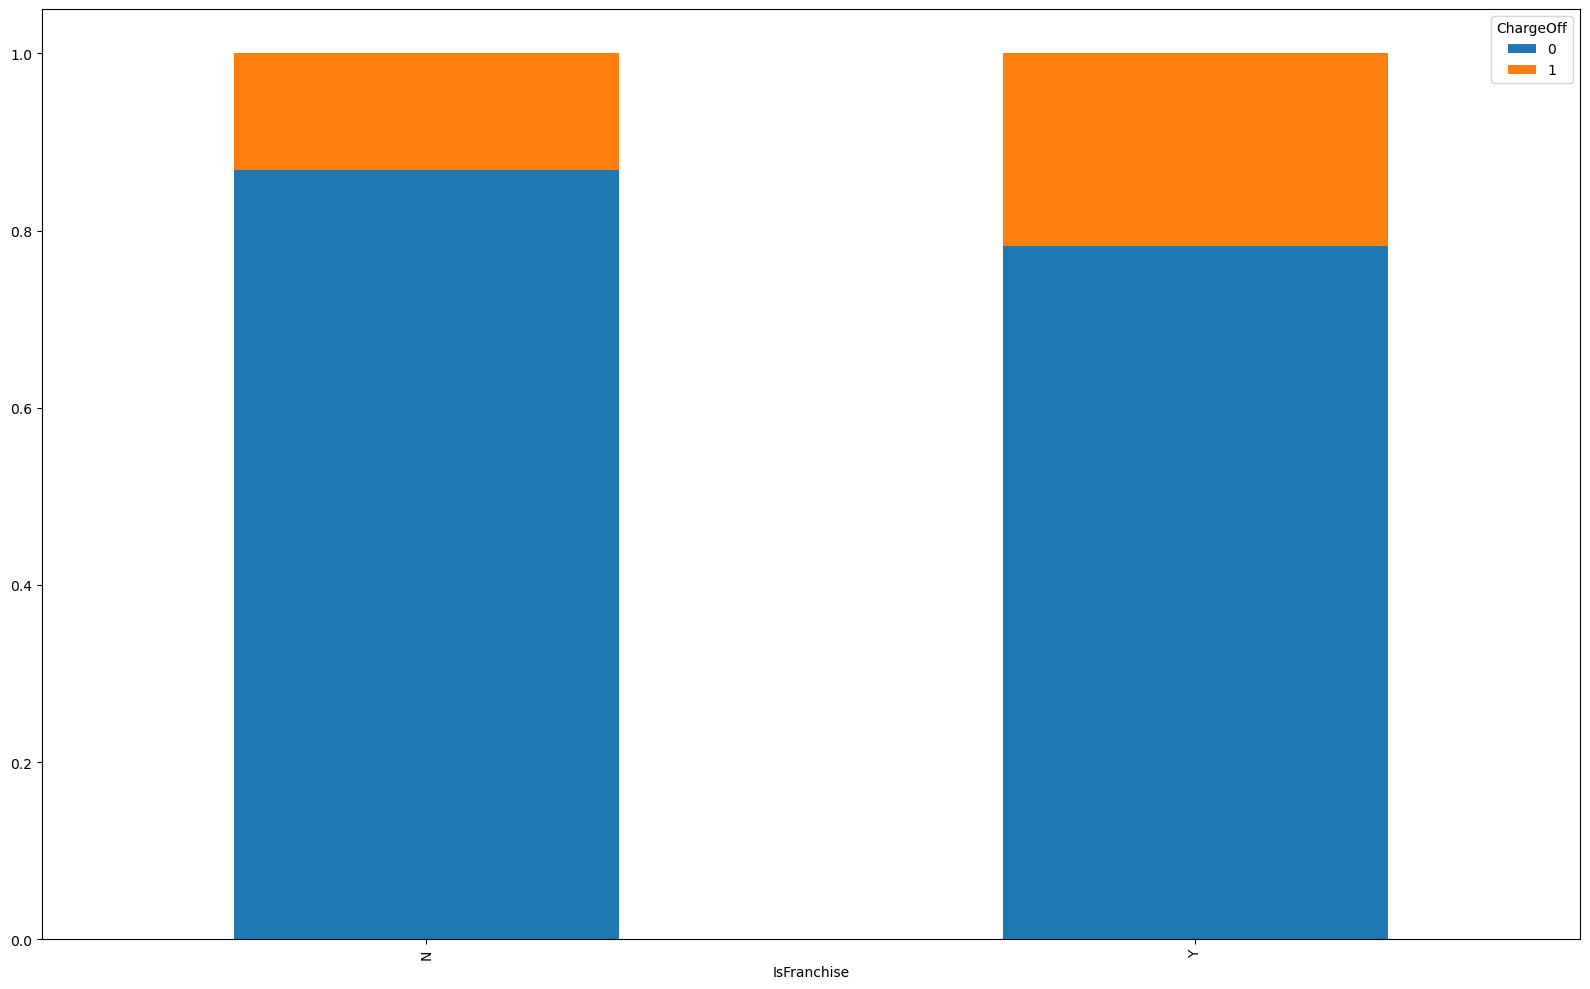

Column NewCity has strong relationship with ChargeOff.


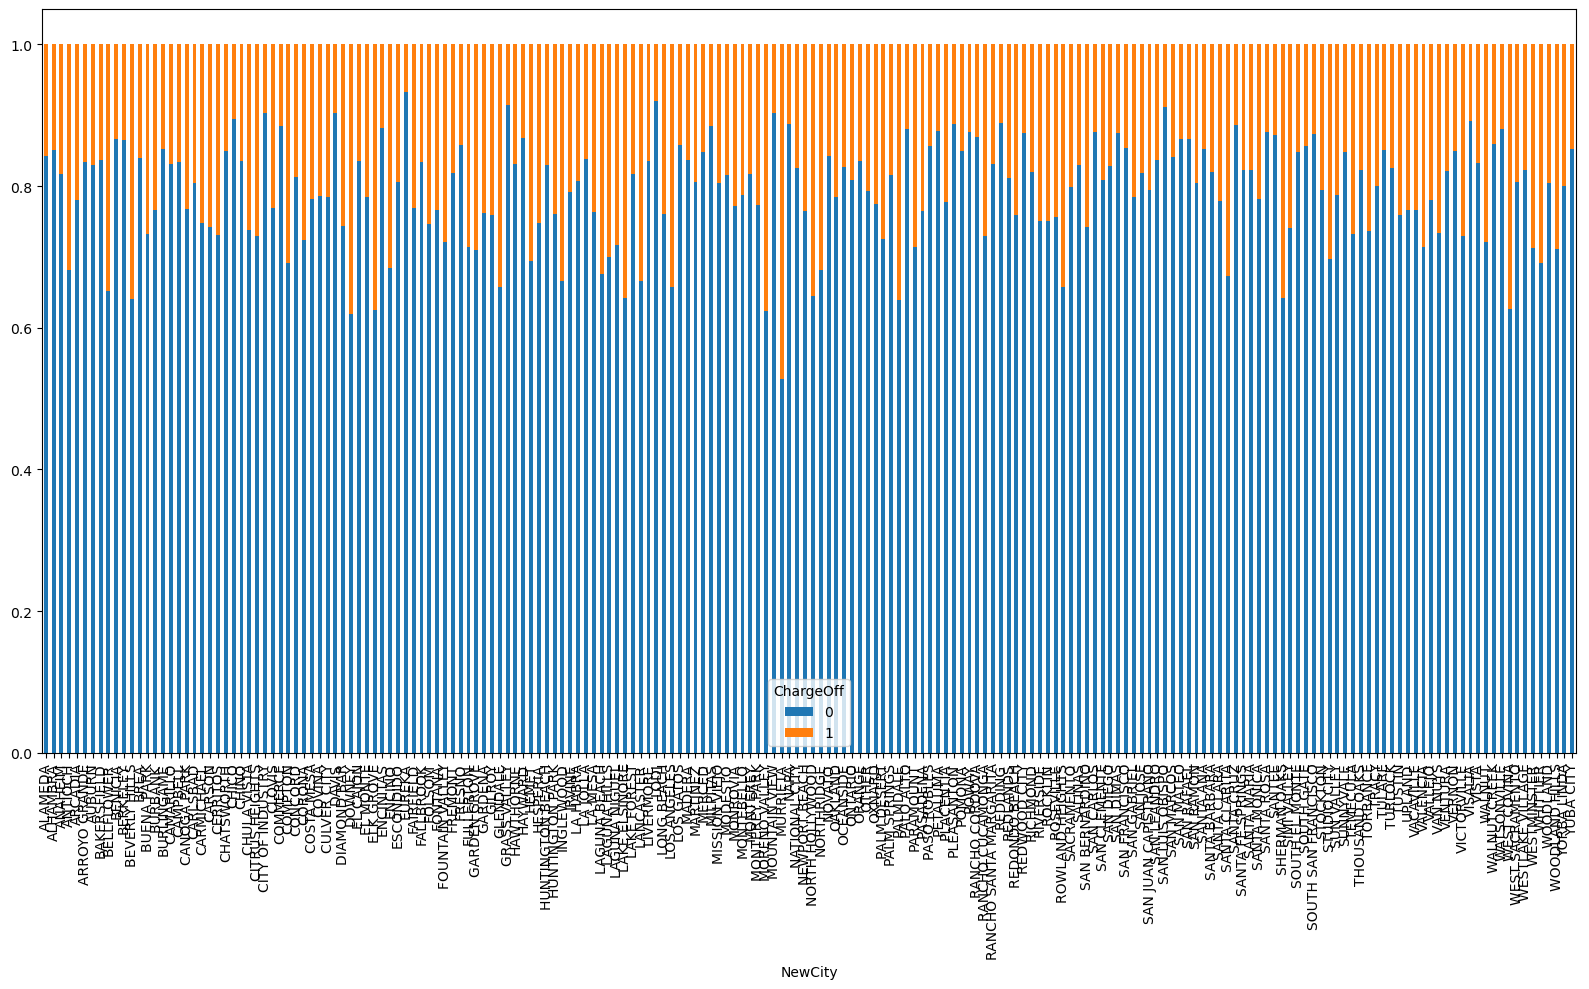

Column NewBank has strong relationship with ChargeOff.


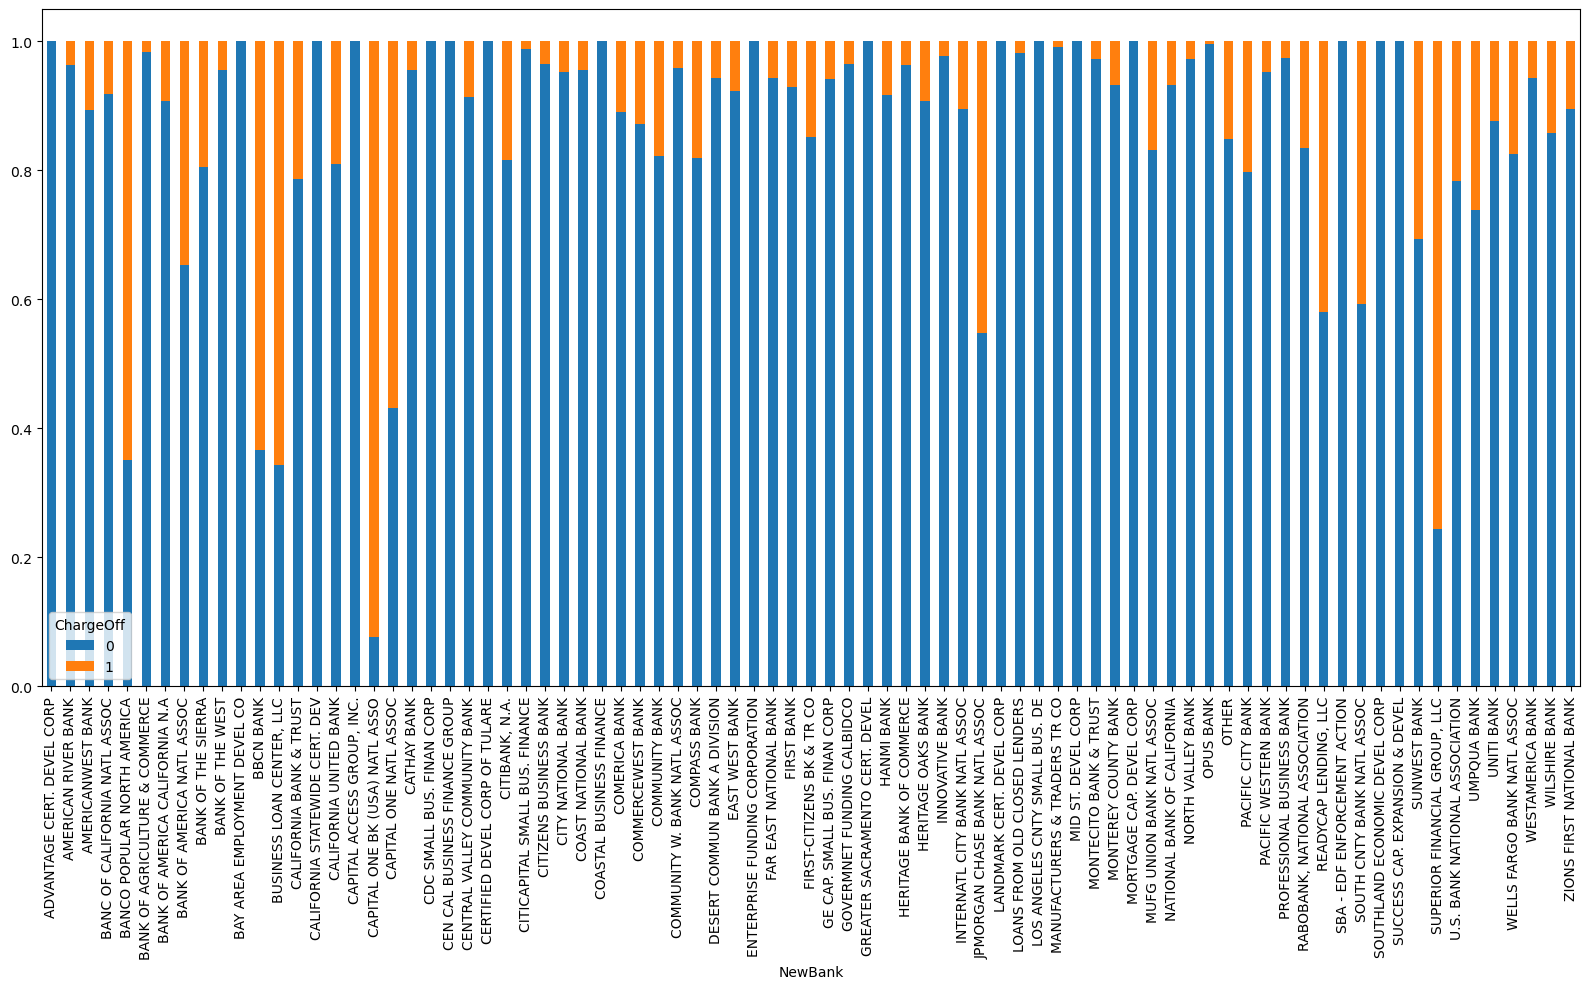

In [251]:
from scipy.stats import chi2_contingency

for col in sba_cat.columns:
    compare_column_ChargeOff(col)

In [253]:
def num_vs_chgoff(column):
    data1 = sba_num[sba5['ChargeOff']==0][column]
    data2 = sba_num[sba5['ChargeOff']==1][column]
    
    stat, p = stats.ttest_ind(a=data1, b=data2, equal_var=True)
    if(p<0.05):
        print(f'Column {column} has strong relationship with MIS Status.')
    else:
        print(f'Column {column} has weak relationship with MIS Status.')

    plt.figure(figsize=(10,5))
    plt.title(f'{col} distribution Split by ChargeOff')
    sns.boxplot(data=sba5, y='ChargeOff', x=column)
    plt.legend()
    plt.show()
    print('------------------------------------------------------------------------------')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Column NoEmp has strong relationship with MIS Status.


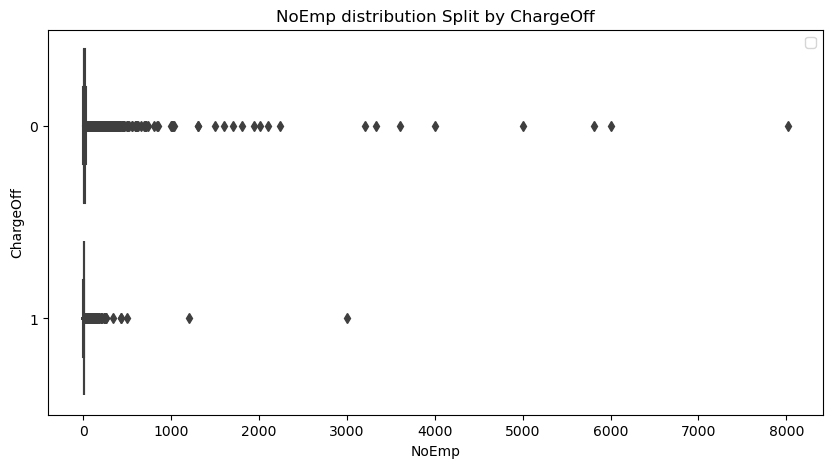

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------------------------------------------------------------------------------
Column NewExist has strong relationship with MIS Status.


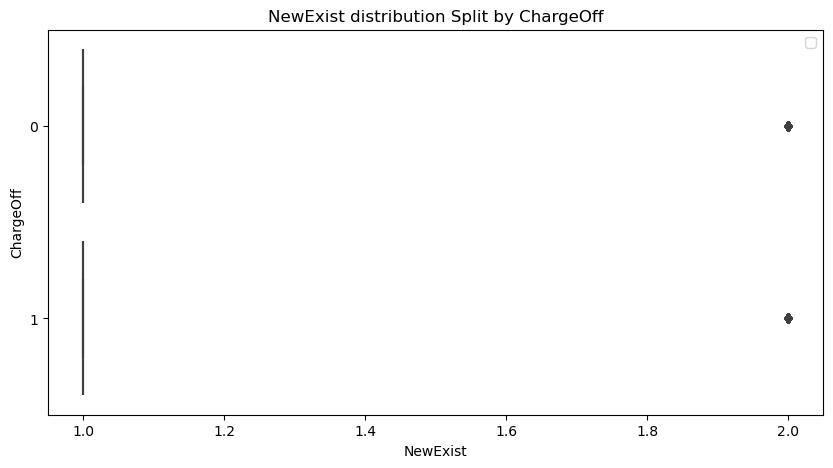

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------------------------------------------------------------------------------
Column CreateJob has weak relationship with MIS Status.


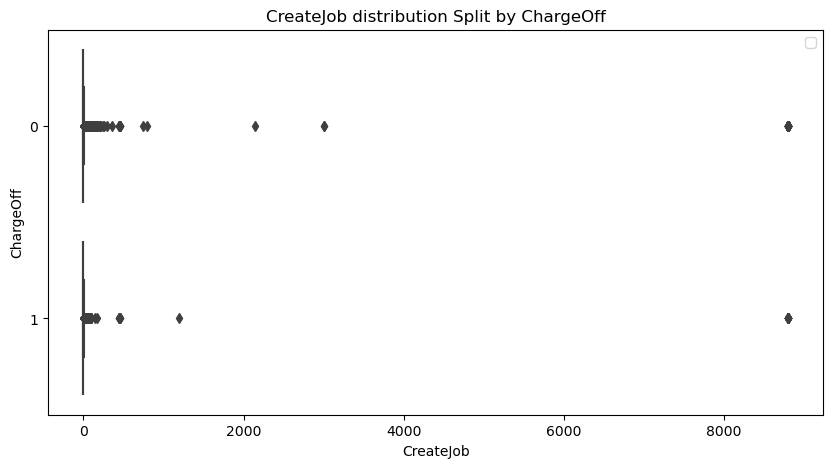

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------------------------------------------------------------------------------
Column RetainedJob has weak relationship with MIS Status.


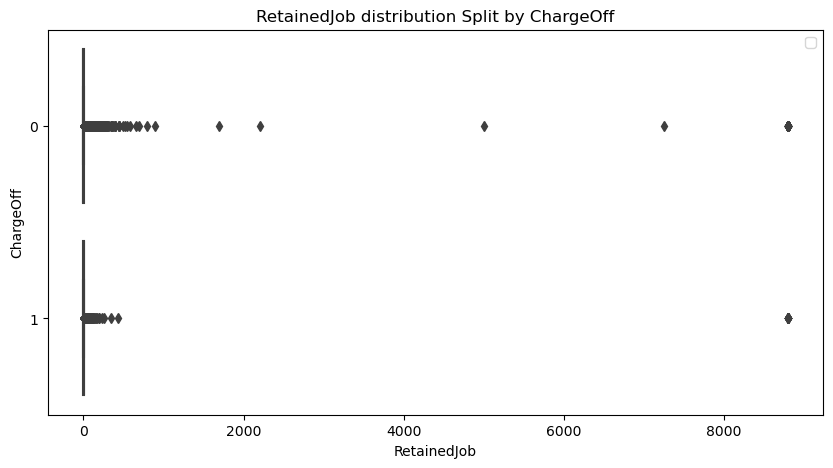

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------------------------------------------------------------------------------
Column ApprovalYear has strong relationship with MIS Status.


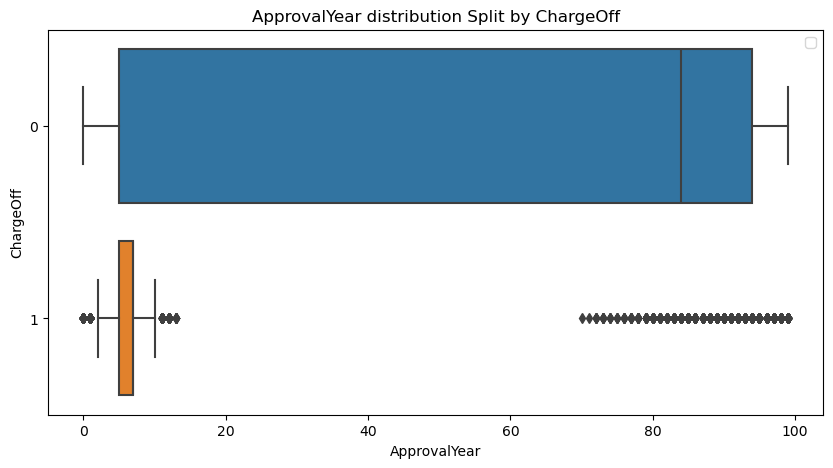

------------------------------------------------------------------------------


In [257]:
from scipy import stats
import seaborn as sns
num_cols = list(sba_num.columns)
num_cols.remove('ChargeOff')
for col in num_cols:
    num_vs_chgoff(col)

In [259]:
sba_num

,NoEmp,NewExist,CreateJob,RetainedJob,ChargeOff,ApprovalYear
0,18,2.0,5,23,0,6
1,3,1.0,2,5,0,6
2,12,1.0,0,0,0,88
3,12,1.0,0,0,0,88
4,5,1.0,1,1,0,9
...,...,...,...,...,...,...
81069,2,1.0,0,2,0,9
81070,59,1.0,0,0,0,99
81071,4,1.0,0,0,0,94
81072,5,2.0,0,0,0,95


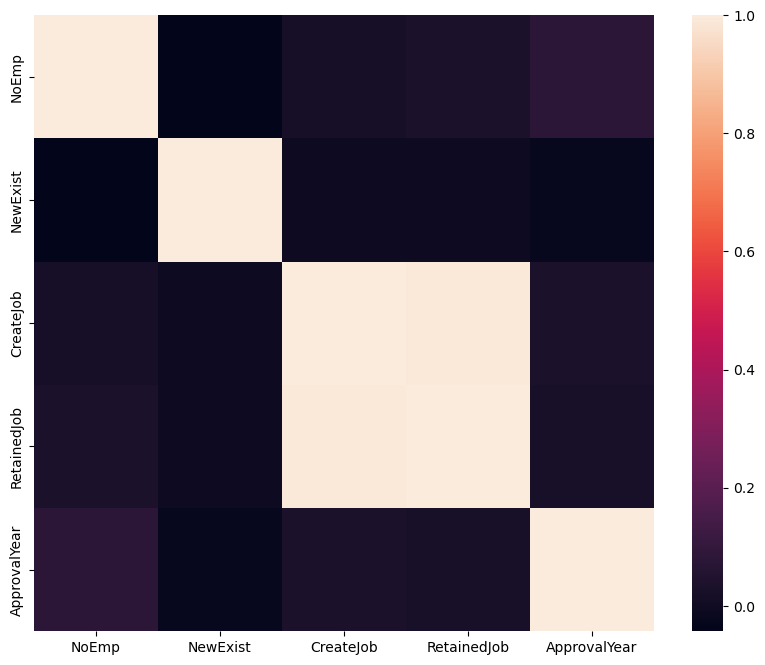

In [265]:
plt.figure(figsize=(10, 8))
sns.heatmap(sba_num.corr())
plt.show()

In [268]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
vif_data = pd.DataFrame()
vif_data["feature"] = sba_num.drop('ChargeOff', axis=1).columns
vif_data["VIF"] = [vif(sba_num.drop('ChargeOff', axis=1).values, i)
                          for i in range(len(sba_num.drop('ChargeOff', axis=1).columns))]
vif_data

,feature,VIF
0,NoEmp,1.057280
1,NewExist,1.770125
2,CreateJob,46.446301
3,RetainedJob,46.495685
4,ApprovalYear,1.778295


In [269]:
print(f'Object columns: {len(sba5.select_dtypes(include="object").columns)}')
print(f'Numeric columns: {len(sba5.select_dtypes(exclude="object").columns)}')

Object columns: 10
Numeric columns: 6


In [270]:
sba5.select_dtypes(include="object").columns

Index(['UrbanRural', 'RevLineCr', 'LowDoc', 'ApprovalMonth', 'Sector',
       'TermGroup', 'NewBankState', 'IsFranchise', 'NewCity', 'NewBank'],
      dtype='object')

In [271]:
sba5.select_dtypes(exclude="object").columns

Index(['NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'ChargeOff',
       'ApprovalYear'],
      dtype='object')

In [276]:
from sklearn.model_selection import train_test_split
X = sba5.drop(columns=['ChargeOff', 'ApprovalMonth'])
y = sba5['ChargeOff']

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, stratify=y, random_state=1000)

In [277]:
X_train_val.shape, X_test.shape

((60805, 14), (20269, 14))

In [278]:
y_train_val.value_counts()

0    47703
1    13102
Name: ChargeOff, dtype: int64

In [291]:
#Pipeline Rgeresion logistica
one_hot_cols = X.select_dtypes(include='object').columns
numeric_cols = X.select_dtypes(exclude='object').columns
logit = LogisticRegression(solver='liblinear', random_state=2023)
smote = SMOTE(random_state=1000)

logit_pipe_num = Pipeline([
    ('scaler', RobustScaler()),
])

logit_pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(drop='first')),
])

logit_transformer = ColumnTransformer([
    ('pipe_num', logit_pipe_num, numeric_cols),
    ('pipe_cat', logit_pipe_cat, one_hot_cols)
])

logit_pipe_combine = Pipeline([
    ('transformer', logit_transformer),
    ('rfe', RFE(logit)),
    ('resampling', smote),
    ('logit', logit)
])

In [292]:
#Pipeline random forest

rfc = RandomForestClassifier(max_depth=7, min_samples_split=10, random_state=2023)
smote = SMOTE(random_state=1000)

rfc_pipe_num = Pipeline([
    ('scaler', RobustScaler()),
])
rfc_pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(drop='first')),
])

rfc_transformer = ColumnTransformer([
    ('pipe_num', rfc_pipe_num, numeric_cols),
    ('pipe_cat', rfc_pipe_cat, one_hot_cols)
])
rfc_pipe_combine = Pipeline([
    ('transformer', rfc_transformer),
    ('rfe', RFE(rfc)),
    ('resampling', smote),
    ('rfc', rfc)
])

**Atención**: El siguiente código tarda de 2 a 3 horas en compilarse porque usa optuna y busca la mejor combinación entre muchas combinaciones de hiperparámetros. Es por eso que pongo los mejores parámetros después del código. Para que compilar más rápido.

In [293]:
start_time = datetime.now()
skf = StratifiedKFold(n_splits=5)

logit_scoreres = cross_validate(logit_pipe_combine, X_train_val, y_train_val, scoring=['recall', 'precision'], cv=skf, n_jobs=-1, verbose=1, return_train_score=True)
rfc_scoreres = cross_validate(rfc_pipe_combine, X_train_val, y_train_val, scoring=['recall', 'precision'], cv=skf, n_jobs=-1, verbose=1, return_train_score=True)

recall_res = [
    np.mean(logit_scoreres['test_recall']),
    np.mean(logit_scoreres['train_recall']),
    np.mean(rfc_scoreres['test_recall']),
    np.mean(rfc_scoreres['train_recall'])
]
precision_res = [
    np.mean(logit_scoreres['test_precision']),
    np.mean(logit_scoreres['train_precision']),
    np.mean(rfc_scoreres['test_precision']),
    np.mean(rfc_scoreres['train_precision'])
]
compare = pd.DataFrame({'model':[logit_pipe_combine['logit'],logit_pipe_combine['logit'],rfc_pipe_combine['rfc'],rfc_pipe_combine['rfc']],
                        'data' :['TEST', 'TRAIN', 'TEST', 'TRAIN'],
                        'recall': recall_res,
                       'precision': precision_res})

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
display(compare)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 54.2min remaining: 81.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 54.2min finished


Duration: 0:57:04.542797


,model,data,recall,precision
0,"LogisticRegression(random_state=2023, solver='...",TEST,0.850634,0.432951
1,"LogisticRegression(random_state=2023, solver='...",TRAIN,0.857121,0.436663
2,"RandomForestClassifier(max_depth=7, min_sample...",TEST,0.869867,0.413138
3,"RandomForestClassifier(max_depth=7, min_sample...",TRAIN,0.872939,0.414349


In [305]:
import time
from timeit import timeit
def rfc_optimize(trial):
    start_time = time.time()
    params = {
        'max_depth': trial.suggest_int("max_depth", 5, 8),
        'min_samples_split': trial.suggest_int('min_samples_split', 10, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 9),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
    }
    rfc_pipe_combine = Pipeline([
        ('transformer', rfc_transformer),
        ('rfe', RFE(rfc)),
        ('resampling', smote),
        ('rfc', RandomForestClassifier(**params, random_state=2023))
    ])

    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1000)
    inner_scores = cross_val_score(rfc_pipe_combine, X_train_val, y_train_val, cv=inner_cv, scoring='f1', n_jobs=4)

    cv_score = np.mean(inner_scores)
    end_time = time.time()
    print(f"Tiempo de ejecución de un ensayo: {end_time - start_time} segundos")
    print(f"Next Trial")
    return cv_score

In [306]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=1000), study_name='RFCSBALoanApproval 1.0')
study.optimize(rfc_optimize, n_trials=5)

[I 2024-04-28 20:40:45,262] A new study created in memory with name: no-name-0dd65c77-56a5-4efb-b70a-25f541ff1cf1
[W 2024-04-28 20:49:23,574] Trial 0 failed with parameters: {'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 8, 'criterion': 'gini'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\susana\miniconda3\envs\mlops_v2\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\susana\AppData\Local\Temp\ipykernel_27104\3615882583.py", line 19, in rfc_optimize
    inner_scores = cross_val_score(rfc_pipe_combine, X_train_val, y_train_val, cv=inner_cv, scoring='f1', n_jobs=4)
  File "C:\Users\susana\miniconda3\envs\mlops_v2\lib\site-packages\sklearn\model_selection\_validation.py", line 515, in cross_val_score
    cv_results = cross_validate(
  File "C:\Users\susana\miniconda3\envs\mlops_v2\lib\site-packages\sklearn\model_selection\_validation.py", line 

KeyboardInterrupt: 

In [ ]:
best_params = study.best_params
print(best_params)

In [307]:
best_params = {'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 6, 'criterion': 'gini'}

In [308]:
rfc_best = RandomForestClassifier(**best_params, random_state=1000)
    
rfc_pipe_combine = Pipeline([
    ('transformer', rfc_transformer),
    ('rfe', RFE(rfc)),
    ('resampling', smote),
    ('rfc', rfc_best)
    ])

rfc_pipe_combine.fit(X_train_val, y_train_val)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  Index(['NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'ApprovalYear'], dtype='object')),
                                                 ('pipe_cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['UrbanRural', 'RevLineCr', 'LowDoc', 'Sector', 'TermGroup',
       'NewBankState', 'IsFranchise', 'NewCity', 'NewBank'],
      dtype='object'))])),
                ('rfe',
                 RFE(estimator=RandomForestClassifier(max_depth=7,
                                                      min_samples_split=10,
                                                      random_state=2023))),
                ('resampling', SMOTE(random_state=2023)),
                ('rfc',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=6,
                                        min_samples_split=12,
                                        random_state=1000))])

In [309]:
recall_score(y_test,rfc_pipe_combine.predict(X_test))

0.8761446886446886

In [310]:
y_scores = rfc_pipe_combine.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test.values, y_scores)
df_thres = pd.DataFrame({'Precision': precision[:-1], 'Recall': recall[:-1], 'Threshold': thresholds})
df_thres[df_thres['Recall'].between(.85, .9)]

,Precision,Recall,Threshold
9371,0.405509,0.899954,0.465784
9372,0.405592,0.899954,0.465889
9373,0.405531,0.899725,0.465903
9374,0.405573,0.899725,0.465936
9375,0.405615,0.899725,0.465938
...,...,...,...
10617,0.444617,0.850046,0.528736
10618,0.444671,0.850046,0.528769
10619,0.444724,0.850046,0.528786
10620,0.444777,0.850046,0.528796


In [311]:
pred_40 = np.where(y_scores>0.403914, 1, 0)
confusion_matrix(y_test,pred_40)

array([[9674, 6227],
       [ 346, 4022]], dtype=int64)

In [312]:
recall_40 = recall_score(y_test,pred_40)
recall_40

0.9207875457875457

In [313]:
precision_40 = precision_score(y_test,pred_40)
precision_40

0.3924285296126451

In [315]:
import joblib
joblib.dump(rfc_pipe_combine, 'modelo_loan.pkl')

['modelo_loan.pkl']

Exploración de valores del dataframe

In [316]:
sba5.columns

Index(['NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'UrbanRural',
       'RevLineCr', 'LowDoc', 'ChargeOff', 'ApprovalMonth', 'ApprovalYear',
       'Sector', 'TermGroup', 'NewBankState', 'IsFranchise', 'NewCity',
       'NewBank'],
      dtype='object')

In [320]:
sba_cat.columns

Index(['UrbanRural', 'RevLineCr', 'LowDoc', 'ApprovalMonth', 'Sector',
       'TermGroup', 'NewBankState', 'IsFranchise', 'NewCity', 'NewBank'],
      dtype='object')

In [355]:
sba5[sba5['ChargeOff']==0].index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            81062, 81063, 81064, 81065, 81067, 81069, 81070, 81071, 81072,
            81073],
           dtype='int64', length=63604)

In [347]:
print(X.shape)
print(sba5.shape)

(81074, 14)
(81074, 16)


In [367]:
X_0_81067 =X.to_dict(orient='records')[81067]
X_1_14 =X.iloc[14]

In [368]:
X_0_81067

{'NoEmp': 7,
 'NewExist': 2.0,
 'CreateJob': 0,
 'RetainedJob': 0,
 'UrbanRural': 'Rural',
 'RevLineCr': 'N',
 'LowDoc': 'N',
 'ApprovalYear': 0,
 'Sector': 'Arts, Entertainment, and Recreation',
 'TermGroup': '3-6 months',
 'NewBankState': 'CA',
 'IsFranchise': 'Y',
 'NewCity': 'OTHER',
 'NewBank': 'OTHER'}

In [369]:
rfc_pipe_combine.predict(pd.DataFrame(X_0_81067, index=[0]))

array([0], dtype=int64)

In [371]:
X_prueba = {'NoEmp': 3,
 'NewExist': 1.0,
 'CreateJob': 1,
 'RetainedJob': 4,
 'UrbanRural': 'Urban',
 'RevLineCr': 'Y',
 'LowDoc': 'N',
 'ChargeOff': 1,
 'ApprovalMonth': 'Apr',
 'ApprovalYear': 6,
 'Sector': 'Professional, Scientific, and Technical Services',
 'TermGroup': 'Below 3 months',
 'NewBankState': 'SD',
 'IsFranchise': 'Y',
 'NewCity': 'CHICO',
 'NewBank': 'WELLS FARGO BANK NATL ASSOC'}

In [372]:
rfc_pipe_combine.predict(pd.DataFrame(X_prueba, index=[0]))

array([1], dtype=int64)

In [379]:
import joblib
model = joblib.load('C:/Users/susana/PycharmProjects/mioti-mlops-Rubio/api/modelo_loan.pkl')
model.predict(pd.DataFrame(X_prueba, index=[0]))

array([1], dtype=int64)

In [333]:
sba_num.columns

Index(['NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'ChargeOff',
       'ApprovalYear'],
      dtype='object')

In [334]:
sba_num.describe()

,NoEmp,NewExist,CreateJob,RetainedJob,ApprovalYear
count,81074.000000,81074.000000,81074.000000,81074.000000,81074.000000
mean,13.335595,1.163443,10.572773,13.502603,41.973062
std,61.962910,0.369772,271.738714,273.339028,43.572180
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000,0.000000,5.000000
50%,5.000000,1.000000,0.000000,1.000000,8.000000
75%,12.000000,1.000000,1.000000,4.000000,93.000000
max,8018.000000,2.000000,8800.000000,8800.000000,99.000000


In [335]:
for column in sba_num.columns:
    print(sba5[column].value_counts())

1       11585
2       10981
3        7966
4        6673
5        5669
        ...  
191         1
850         1
369         1
5812        1
1940        1
Name: NoEmp, Length: 302, dtype: int64
1.0    67823
2.0    13251
Name: NewExist, dtype: int64
0      57621
1       5823
2       5010
3       2194
5       1662
       ...  
300        1
140        1
138        1
73         1
136        1
Name: CreateJob, Length: 125, dtype: int64
0      39043
1       7823
2       6704
3       4703
4       3726
       ...  
342        1
660        1
147        1
102        1
114        1
Name: RetainedJob, Length: 203, dtype: int64
0    63604
1    17470
Name: ChargeOff, dtype: int64
7     8432
6     7154
5     5384
4     5207
3     5056
94    4094
93    3441
2     3436
95    3338
92    3087
96    2958
91    2852
98    2634
8     2628
97    2566
90    2428
1     2417
99    2219
89    2153
0     2136
9     1845
10    1757
11    1034
12     644
88     562
85     231
86     226
13     223
87     220
84     

In [ ]:
for column in sba_cat.columns:
    print(sba5[column].value_counts())